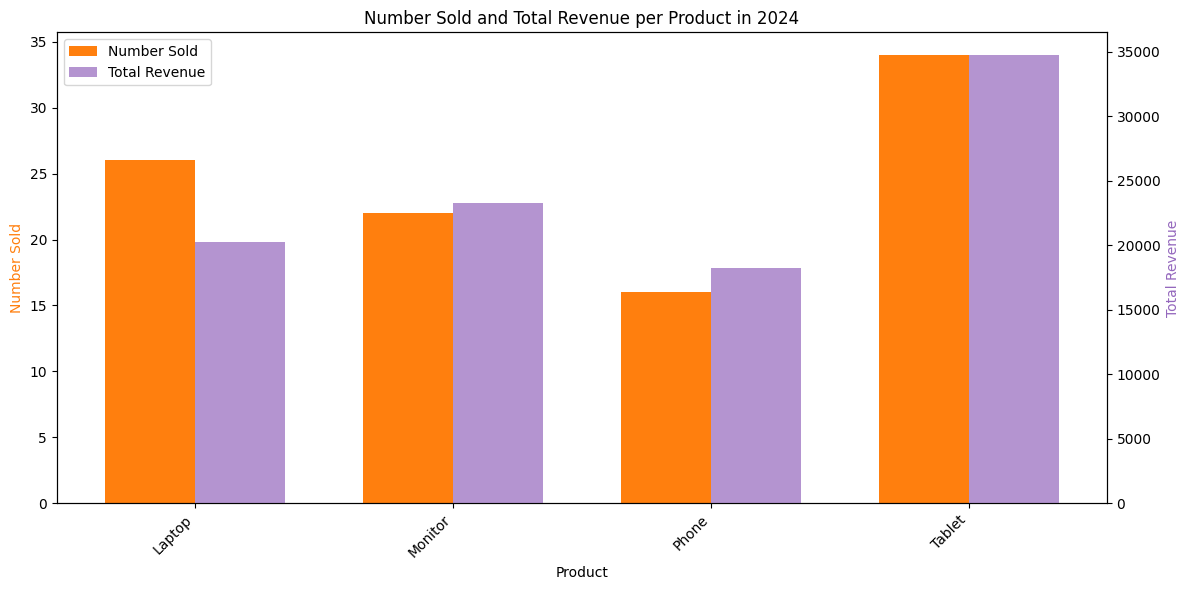

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your transformed data (adjust path as needed)
df = pd.read_csv('transformed/transformed_full.csv')

# Ensure order_date is datetime
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

# Filter for dates in 2024 only
df_2024 = df[df['order_date'].dt.year == 2024]

# Remove rows with missing or invalid dates
df_2024 = df_2024[df_2024['order_date'].notnull()]

# Grouped bar chart for number sold and total revenue per product
if not df_2024.empty and 'product' in df_2024.columns and 'total_price' in df_2024.columns:
    product_counts = df_2024['product'].value_counts().sort_index()
    revenue_per_product = df_2024.groupby('product')['total_price'].sum().sort_index()
    products = product_counts.index
    
    x = np.arange(len(products))
    width = 0.35
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    bars1 = ax1.bar(x - width/2, product_counts[products], width, label='Number Sold', color='tab:orange')
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x + width/2, revenue_per_product[products], width, label='Total Revenue', color='tab:purple', alpha=0.7)
    
    ax1.set_xlabel('Product')
    ax1.set_ylabel('Number Sold', color='tab:orange')
    ax2.set_ylabel('Total Revenue', color='tab:purple')
    ax1.set_xticks(x)
    ax1.set_xticklabels(products, rotation=45, ha='right')
    
    # Add legends
    ax1.legend([bars1, bars2], ['Number Sold', 'Total Revenue'], loc='upper left')
    plt.title('Number Sold and Total Revenue per Product in 2024')
    fig.tight_layout()
    plt.show()
else:
    print('No product or revenue data found for 2024.')

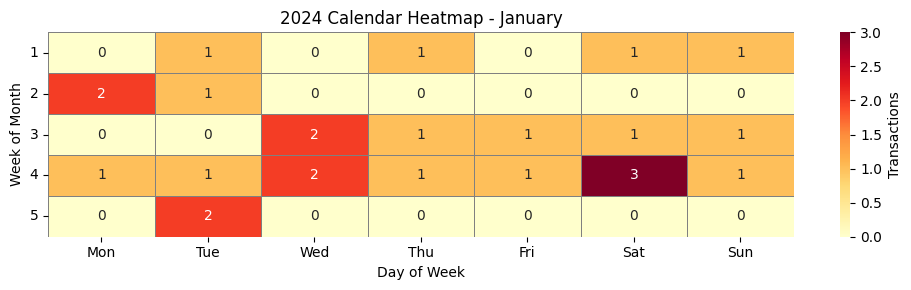

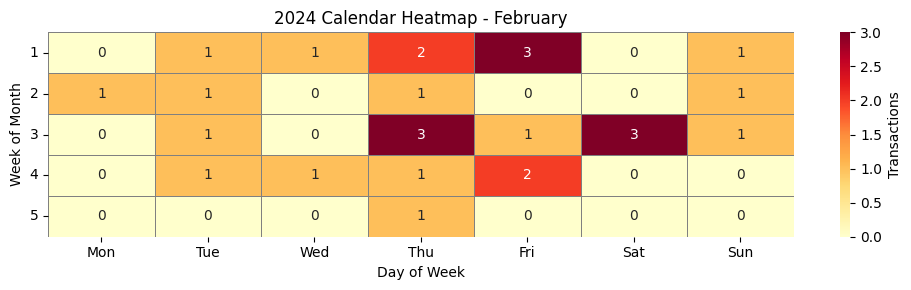

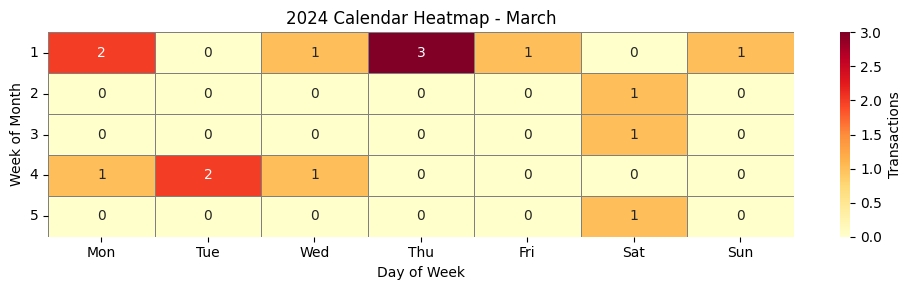

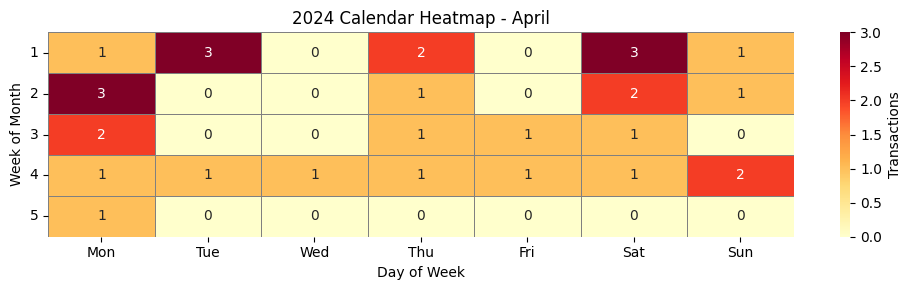

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import sqlite3

# Load data from the SQLite database
conn = sqlite3.connect('loaded/etl_results.db')
df = pd.read_sql_query('SELECT * FROM full_data', conn)
conn.close()

# Ensure order_date is datetime
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

# Filter for dates in 2024 only
df_2024 = df[df['order_date'].dt.year == 2024]

# Remove rows with missing or invalid dates
df_2024 = df_2024[df_2024['order_date'].notnull()]

if not df_2024.empty:
    # Group by date and count transactions (as integers)
    daily_counts = df_2024.groupby('order_date').size().astype(int)
    # Create a DataFrame with all days in 2024 up to the latest date in the data
    min_date = daily_counts.index.min()
    max_date = daily_counts.index.max()
    all_days = pd.date_range(min_date, max_date, freq='D')
    daily_counts = daily_counts.reindex(all_days, fill_value=0).astype(int)
    df_heat = pd.DataFrame({'date': all_days, 'count': daily_counts.values})
    df_heat['month'] = df_heat['date'].dt.month
    df_heat['day'] = df_heat['date'].dt.day
    df_heat['weekday'] = df_heat['date'].dt.weekday
    
    # Pivot for heatmap: rows=week, columns=weekday, values=count, for each month in the data
    months_in_data = df_heat['month'].unique()
    for month in months_in_data:
        month_data = df_heat[df_heat['month'] == month]
        # Get week number within the month
        month_data = month_data.copy()
        month_data['week'] = ((month_data['day'] - 1) // 7) + 1
        heatmap_data = month_data.pivot(index='week', columns='weekday', values='count')
        plt.figure(figsize=(10, 3))
        sns.heatmap(heatmap_data.fillna(0).astype(int), cmap='YlOrRd', linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Transactions'}, annot=True, fmt='d')
        plt.title(f'2024 Calendar Heatmap - {calendar.month_name[month]}')
        plt.xlabel('Day of Week')
        plt.ylabel('Week of Month')
        plt.xticks(ticks=[i+0.5 for i in range(7)], labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation=0)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
else:
    print('No transactions found for 2024.')